In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import os

In [2]:
# Load the Dataset
file_path = ".../data/training_data/BTCUSDT/BTCUSDT_2022-01-01_2024-11-01_5.csv"
df = pd.read_csv(file_path)
df = pd.DataFrame(df)
columns_to_keep = ['Timestamp','Close', 'Volume', 'SMA_50',
       'SMA_200', 'EMA_50', 'EMA_200', 'MACD', 'MACD_Signal','MACD_Hist',
       'RSI', 'BB_upper', 'BB_middle', 'BB_lower']

df_filtered = df[columns_to_keep]
df = df_filtered.dropna()

Model Architecture:
LSTMWithResidualAndAttention(
  (lstm_y): LSTM(1, 64, batch_first=True)
  (lstm_p): LSTM(2, 64, batch_first=True)
  (lstm_n): LSTM(2, 64, batch_first=True)
  (residual): ResidualBlock(
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation1): ReLU()
    (linear2): Linear(in_features=32, out_features=64, bias=True)
    (norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation2): ReLU()
    (downsample): Linear(in_features=64, out_features=64, bias=True)
  )
  (attention): AttentionLayer()
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Number of trainable parameters:
64,801
Epoch 1, Train Loss: 0.000971, Val Loss: 0.001223, LR: 1.000000e-03
Saved new best model.
Epoch 2, Train Loss: 0.000088, Val Loss: 0.000879, LR: 1.000000e-03
Saved new best model.
Epoch 3, Train Loss: 0.000054, Val Loss:

C:\Users\maxru\AppData\Local\Temp\ipykernel_21672\1547577875.py:263: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("MultiInputLSTM_Residual_

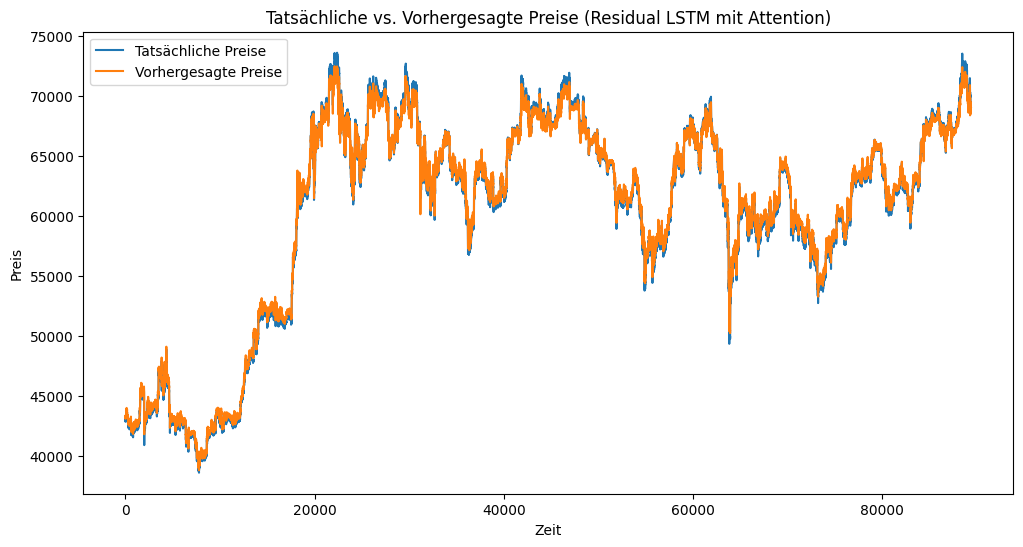

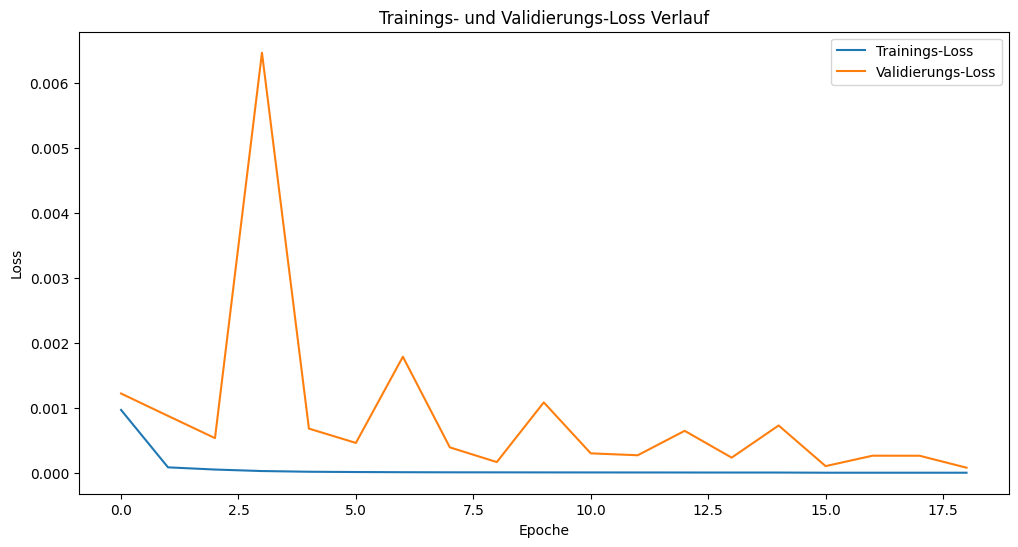

In [3]:
# Feature-Auswahl
features = ['SMA_50', 'SMA_200', 'EMA_50', 'EMA_200', 'MACD_Signal']
target = 'Close'

# Daten vorbereiten
prices = df['Close'].values.reshape(-1, 1)

X = df[features].values.copy()
y = df[target].values.copy()

scaler_X = RobustScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = RobustScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(X_scaled) * 0.7)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

# Funktion zur Sequenz-Erstellung
def create_sequences(X, y, sequence_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:i + sequence_length])
        y_seq.append(y[i + sequence_length])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 60
X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)

# Dataset und DataLoader für PyTorch
class MultiInputTimeSeriesDataset(Dataset):
    def __init__(self, X, y, sequence_length):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X_seq = self.X[idx]
        y_target = self.y[idx]
        Y = X_seq[:, 0].unsqueeze(-1)
        X_p = X_seq[:, 1:3]
        X_n = X_seq[:, 3:5]
        return Y, y_target, X_p, X_n

batch_size = 64

train_dataset = MultiInputTimeSeriesDataset(X_train_seq, y_train_seq, sequence_length)
test_dataset = MultiInputTimeSeriesDataset(X_test_seq, y_test_seq, sequence_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class ResidualBlock(nn.Module):
  def __init__(self, input_dim, hidden_dim, activation=nn.ReLU, normalization=nn.BatchNorm1d):
      """
      Residual block with skip connections.
      Args:
          input_dim (int): Dimension of the input features.
          hidden_dim (int): Dimension of the hidden layer.
          activation (callable): Activation function class (default: ReLU).
          normalization (callable): Normalization layer class (default: BatchNorm1d).
      """
      super(ResidualBlock, self).__init__()
      self.input_dim = input_dim
      self.hidden_dim = hidden_dim

      # First layer: Linear -> Normalization -> Activation
      self.linear1 = nn.Linear(input_dim, hidden_dim)
      self.norm1 = normalization(hidden_dim)
      self.activation1 = activation()

      # Second layer: Linear -> Normalization -> Activation
      self.linear2 = nn.Linear(hidden_dim, input_dim)
      self.norm2 = normalization(input_dim)
      self.activation2 = activation()

      # Shortcut connection: Optional downsampling if dimensions don't match
      self.downsample = (
          nn.Linear(input_dim, input_dim) if input_dim != hidden_dim else nn.Identity()
      )

  def forward(self, x):
      """
      Forward pass through the residual block.
      Args:
          x (Tensor): Input tensor of shape (batch_size, input_dim).
      Returns:
          Tensor: Output tensor of the same shape as input.
      """
      # Store the original input for the skip connection
      residual = self.downsample(x)

      # Pass through the first layer
      out = self.linear1(x)
      out = self.norm1(out)
      out = self.activation1(out)

      # Pass through the second layer
      out = self.linear2(out)
      out = self.norm2(out)

      # Add the residual (skip connection) and apply the activation
      out += residual
      out = self.activation2(out)

      return out

# Attention Layer
class AttentionLayer(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionLayer, self).__init__()
        self.attention_weights = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.attention_bias = nn.Parameter(torch.Tensor(hidden_size))
        self.attention_vector = nn.Parameter(torch.Tensor(hidden_size))

        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.attention_weights)
        nn.init.zeros_(self.attention_bias)
        nn.init.uniform_(self.attention_vector, -0.1, 0.1)

    def forward(self, hidden_states):
        attention_scores = torch.tanh(torch.matmul(hidden_states, self.attention_weights) + self.attention_bias)
        attention_scores = torch.matmul(attention_scores, self.attention_vector)
        attention_weights = torch.softmax(attention_scores, dim=1)
        weighted_hidden_states = hidden_states * attention_weights.unsqueeze(-1)
        context_vector = weighted_hidden_states.sum(dim=1)
        return context_vector

# MultiInputLSTM with Residual and Attention Layers
class LSTMWithResidualAndAttention(nn.Module):
    def __init__(self, input_size_pn, hidden_size, residual_dim):
        super(LSTMWithResidualAndAttention, self).__init__()
        self.lstm_y = nn.LSTM(input_size=1, hidden_size=hidden_size, batch_first=True)
        self.lstm_p = nn.LSTM(input_size=input_size_pn, hidden_size=hidden_size, batch_first=True)
        self.lstm_n = nn.LSTM(input_size=input_size_pn, hidden_size=hidden_size, batch_first=True)

        # Residual Block
        self.residual = ResidualBlock(hidden_size, residual_dim)

        # Attention Layer
        self.attention = AttentionLayer(hidden_size)

        # Fully connected layer for final output
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, Y, X_p, X_n):
        # Process inputs through LSTM layers
        Y_out, _ = self.lstm_y(Y)
        X_p_out, _ = self.lstm_p(X_p)
        X_n_out, _ = self.lstm_n(X_n)

        # Combine LSTM outputs
        combined = Y_out[:, -1, :] + X_p_out[:, -1, :] + X_n_out[:, -1, :]

        # Apply Residual Block
        combined_residual = self.residual(combined)

        # Apply Attention Layer
        attention_output = self.attention(combined_residual.unsqueeze(1))  # Adding sequence dimension

        # Final output
        output = self.fc(attention_output)
        return output

# Initialize the model
input_size_pn = 2
hidden_size = 64
residual_dim = 32

model = LSTMWithResidualAndAttention(input_size_pn=input_size_pn, hidden_size=hidden_size, residual_dim=residual_dim)

def model_summary(model):
    print("Model Architecture:")
    print(model)
    print("\nNumber of trainable parameters:")
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{total_params:,}")

# Gebe die Modellzusammenfassung aus
model_summary(model)

# Training and optimization setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Early Stopping and Adaptive Learning Rate Parameters
patience = 10  # Number of epochs to wait before stopping after no improvement
lr_patience = 5  # Number of epochs with no improvement to reduce learning rate
min_delta = 1e-4  # Minimum change in validation loss to qualify as an improvement
factor = 0.5  # Factor by which the learning rate is reduced
early_stop = False
best_val_loss = float('inf')
early_stop_counter = 0

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=lr_patience)

# Training Loop with Early Stopping and Adaptive Learning Rate
train_losses, val_losses = [], []

for epoch in range(1, 1001):  # Large epoch number to let early stopping control the training
    model.train()
    train_loss = 0.0
    for Y, y_target, X_p, X_n in train_loader:
        Y, y_target, X_p, X_n = Y.to(device), y_target.to(device), X_p.to(device), X_n.to(device)

        optimizer.zero_grad()
        predictions = model(Y, X_p, X_n)
        loss = criterion(predictions.squeeze(), y_target.squeeze())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for Y, y_target, X_p, X_n in test_loader:
            Y, y_target, X_p, X_n = Y.to(device), y_target.to(device), X_p.to(device), X_n.to(device)
            predictions = model(Y, X_p, X_n)
            loss = criterion(predictions.squeeze(), y_target.squeeze())
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    # Adjust learning rate
    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, LR: {optimizer.param_groups[0]['lr']:.6e}")

    # Check for improvement
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "MultiInputLSTM_Residual_Attention.pth")
        print("Saved new best model.")
    else:
        early_stop_counter += 1

    # Early stopping
    if early_stop_counter >= patience:
        print("Early stopping triggered.")
        early_stop = True
        break

# Load the best model
model.load_state_dict(torch.load("MultiInputLSTM_Residual_Attention.pth"))

# Predictions
model.eval()
train_predictions, test_predictions = [], []
with torch.no_grad():
    for Y, y_target, X_p, X_n in train_loader:
        Y, X_p, X_n = Y.to(device), X_p.to(device), X_n.to(device)
        outputs = model(Y, X_p, X_n)
        train_predictions.extend(outputs.cpu().numpy())
    for Y, y_target, X_p, X_n in test_loader:
        Y, X_p, X_n = Y.to(device), X_p.to(device), X_n.to(device)
        outputs = model(Y, X_p, X_n)
        test_predictions.extend(outputs.cpu().numpy())

train_predictions = scaler_y.inverse_transform(np.array(train_predictions).reshape(-1, 1))
test_predictions = scaler_y.inverse_transform(np.array(test_predictions).reshape(-1, 1))
y_train_unscaled = scaler_y.inverse_transform(y_train_seq.reshape(-1, 1))
y_test_unscaled = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))

# Visualizations
output_dir = "../Evaluation_PNGs/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Folder '{output_dir}' created for saving the plots.")

plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label='Tatsächliche Preise')
plt.plot(test_predictions, label='Vorhergesagte Preise')
plt.xlabel('Zeit')
plt.ylabel('Preis')
plt.title('Tatsächliche vs. Vorhergesagte Preise (Residual LSTM mit Attention)')
plt.legend()
plt.savefig(os.path.join(output_dir, "MultiInputLSTM_Residual_Attention_price_predictions.png"))
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Trainings-Loss')
plt.plot(val_losses, label='Validierungs-Loss')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.title('Trainings- und Validierungs-Loss Verlauf')
plt.legend()
plt.savefig(os.path.join(output_dir, "MultiInputLSTM_Residual_Attention_loss_curves.png"))
plt.show()


In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Load your data
file_path = '../data/training_data/BTCUSDT/BTCUSDT_2022-01-01_2024-11-01_5.csv'
df = pd.read_csv(file_path)
data = df['Close'].values

# Calculate the changes in the data
changes = np.diff(data)

# Calculate the mean and variance of the changes
mean_change = np.mean(changes)
variance_change = np.var(changes)

# Square the variance
squared_variance = variance_change ** 2

# Calculate the Mean Squared Error (MSE) of your model's predictions
# Assuming `test_predictions` and `y_test_unscaled` are already defined
mse = mean_squared_error(y_test_unscaled, test_predictions)

# Compare the squared variance to the MSE
print(f"Mean Change: {mean_change}")
print(f"Variance of Changes: {variance_change}")
print(f"Squared Variance: {squared_variance}")
print(f"Mean Squared Error (MSE): {mse}")

if squared_variance < mse:
    print("The model's MSE is higher than the squared variance of the changes, indicating the model may not be capturing the trend well.")
else:
    print("The model's MSE is lower than the squared variance of the changes, indicating the model may be capturing the trend well.")

Mean Change: 0.07726055129511451
Variance of Changes: 4772.194851470726
Squared Variance: 22773843.7004037
Mean Squared Error (MSE): 126380.75089101553
The model's MSE is lower than the squared variance of the changes, indicating the model may be capturing the trend well.
